# How to use Cohere embeddings and rerank module with MongoDB Atlas Search / Vector Search.
Cohere embeddings are a way of representing text as high-dimensional vectors that capture the semantic meaning and context of the text. Rerank module is a feature of Cohere that allows you to customize the ranking of search results(retrieved from MongoDB Atlas) based on reranker module. Working with Cohere embeddings and rerank module, you can create powerful and flexible vector search applications/Information retrieval systems that can handle natural language queries and also address complex scenarios.

The powerful combination of technologies you can further enhance existing operational data store(ODS) functionality of MongoDB with features such as semantic search, question-answering as in RAG framework, real time threat detection, and plethora of other applications that rely on NLP and Full text search capabilities over Real time and transactions data sources that generate text data a scale.

# What we will do in this tutorial?

### Store Embeddings and Prepare Index
1. Use the Cohere Embed package in python to generate vector embeddings of your documents (or any text data).
2. Add vector embeddings into MongoDB Atlas, which can store and index these vector embeddings along side you other operation data, and finally prepare index for both vetors embeddings as well as full text search on copious amounts of data.

### Search with vector embeddings
1. Write a simple python function to accept search term/phrase and pass it through the Cohere Embed api again.
2. Take these resultant vector embedding and perform a vector search query using the $vectorsearch operator in MongoDB Aggregation Pipeline.
3. The retrieved semantically similar documents can be prefilterd and postfiltered(relevancy score) with simple text, numeric, boolean, range filters to demonstrate a higher degree of control over the semantic search behaviour.

### Search with Text and rerank with Cohere
1. Write a simple python function to accept search term/phrase and perpare a search query using $search operator and MongoDB Aggregation Pipeline.
2. Take these resultant documents perform reranking operation of the retrieved documents to achieve higher accuracy with full text search results using Cohere rerank module.


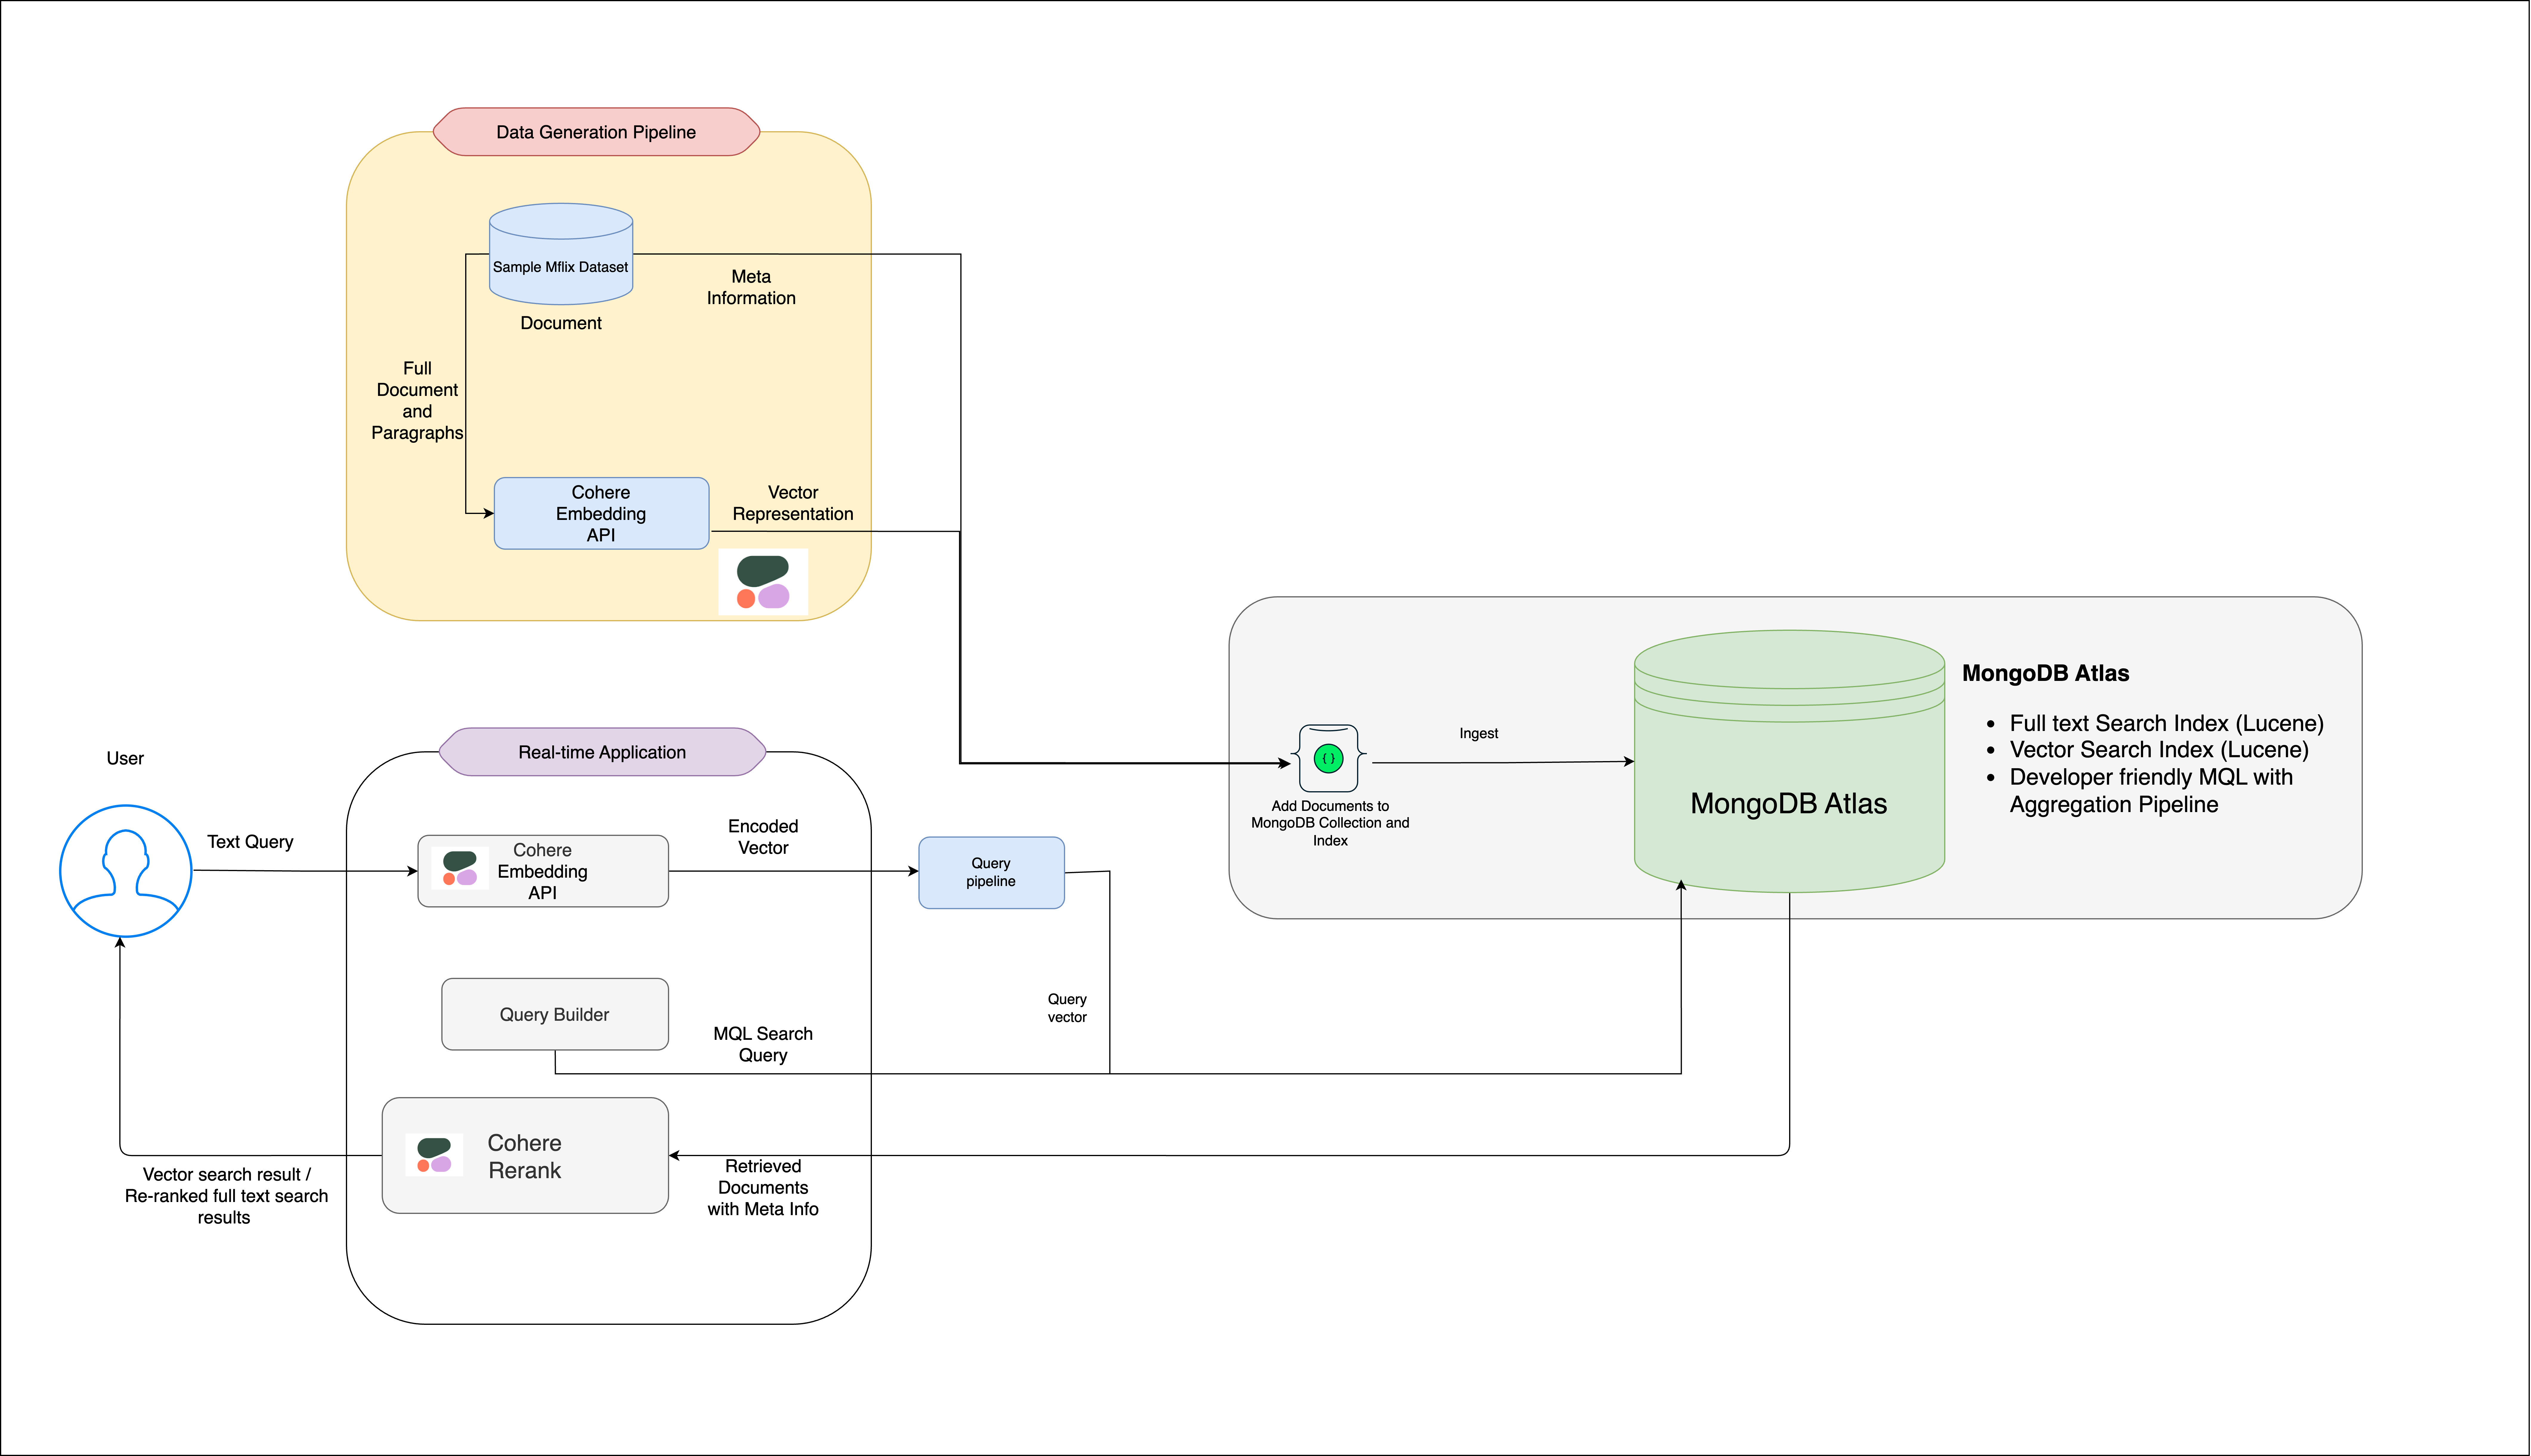

## Install all dependecies

In [10]:
!pip install cohere pymongo pandas getpass os

ERROR: Could not find a version that satisfies the requirement getpass (from versions: none)
ERROR: No matching distribution found for getpass
Note: you may need to restart the kernel to use updated packages.


# Intitialize the packages

In [2]:
import os
import getpass

# Initialize Cohere API Key

In [3]:
try:
    cohere_api_key = os.environ["COHERE_API_KEY"]
except KeyError:
    cohere_api_key = getpass.getpass("Please enter your COHERE API KEY (hit enter): ")

Please enter your COHERE API KEY (hit enter):  ········


# Initialize MongoDB Connection String

In [4]:
try:
    MONGO_CONN_STR = os.environ["MONGO_CONN_STR"]
except KeyError:
    MONGO_CONN = getpass.getpass("Please enter your MongoDB Atlas Connection String (hit enter): ")

Please enter your MongoDB Atlas Connection String (hit enter):  ········


# How to Initialize MongoDB Atlas for testing Cohere integration

You can follow the steps mentioned in [link](https://www.mongodb.com/basics/sample-database) to load sample dataset to MongoDB Atlas collection and get you started

In [180]:
from pymongo import MongoClient
mongo_client = MongoClient(MONGO_CONN)
collection = mongo_client["sample_mflix"]["movies"]
# fetch sample document stored in sample_mflix dataset
collection.find_one()

{'_id': ObjectId('573a1390f29313caabcd4135'),
 'plot': 'Three men hammer on an anvil and pass a bottle of beer around.',
 'genres': ['Short'],
 'runtime': 1,
 'cast': ['Charles Kayser', 'John Ott'],
 'num_mflix_comments': 0,
 'title': 'Blacksmith Scene',
 'fullplot': 'A stationary camera looks at a large anvil with a blacksmith behind it and one on either side. The smith in the middle draws a heated metal rod from the fire, places it on the anvil, and all three begin a rhythmic hammering. After several blows, the metal goes back in the fire. One smith pulls out a bottle of beer, and they each take a swig. Then, out comes the glowing metal and the hammering resumes.',
 'countries': ['USA'],
 'released': datetime.datetime(1893, 5, 9, 0, 0),
 'directors': ['William K.L. Dickson'],
 'rated': 'UNRATED',
 'awards': {'wins': 1, 'nominations': 0, 'text': '1 win.'},
 'lastupdated': '2015-08-26 00:03:50.133000000',
 'year': 1893,
 'imdb': {'rating': 6.2, 'votes': 1189, 'id': 5},
 'type': 'movie'

In [ ]:
import pandas as pd
df = pd.DataFrame.from_records(collection.find().limit(1000))
df = df[["genres", "title", "fullplot", "year"]]
df[:3]

,genres,title,fullplot,year
0,[Short],Blacksmith Scene,A stationary camera looks at a large anvil wit...,1893
1,"[Short, Western]",The Great Train Robbery,Among the earliest existing films in American ...,1903
2,"[Short, Drama, Fantasy]",The Land Beyond the Sunset,"Thanks to the Fresh Air Fund, a slum child esc...",1912


# Initialize Cohere Embeddings API and embed the sample_mflix dataset fullplot as vector embeddings

In [102]:
import cohere  
co_client = cohere.Client(cohere_api_key)

In [103]:
embedding = co_client.embed(model="embed-english-v3.0",input_type="search_document",texts=list(df.fullplot.apply(str)))

In [104]:
df["embedding"] = embedding.embeddings

In [105]:
records = df.to_dict(orient="records")

In [107]:
output_collection = mongo_client["sample_mflix"]["cohere_embed_movies"]
e = output_collection.insert_many(records)

In [108]:
# output_collection.delete_many({})

# Programatically create Vector Search and Full text search index in MongoDB Atlas for the respective collection used in the tutorial

In [60]:
output_collection.create_search_index({"definition":
        {"mappings":
         {"dynamic": True,
          "fields": {
            "embedding" : {
                "dimensions": 1024,
                "similarity": "cosine",
                "type": "knnVector"
                },
            "fullplot":
            }}},
     "name": "default"
    }
)

# Python function to embed search term/phrase and perform vectors search query using $vectorsearch operator

In [152]:
def query_vector_search(q, prefilter = {}, postfilter = {},path="embedding",topK=2):
    ele = co_client.embed(model="embed-english-v3.0",input_type="search_document",texts=[q])
    query_embedding = ele.embeddings[0]
    vs_query = {
                "index": "default",
                "path": path,
                "queryVector": query_embedding,
                "numCandidates": 10,
                "limit": topK,
            }
    if len(prefilter)>0:
        vs_query["filter"] = prefilter
    new_search_query = {"$vectorSearch": vs_query}
    project = {"$project": {"score": {"$meta": "vectorSearchScore"},"_id": 0,"title": 1, "year": 1, "fullplot": 1}}
    if len(postfilter.keys())>0:
        postFilter = {"$match":postfilter}
        res = list(output_collection.aggregate([new_search_query, project, postFilter]))
    else:
        res = list(output_collection.aggregate([new_search_query, project]))
    return res
    

# Vector search query example

In [153]:
query_vector_search("movies on agriculture")

[{'title': 'The Land',
  'fullplot': 'Documentary showing the poor state that American agriculture had fallen into during the Great Depression.',
  'year': 1942,
  'score': 0.7468007802963257},
 {'title': 'A Corner in Wheat',
  'fullplot': "A greedy tycoon decides, on a whim, to corner the world market in wheat. This doubles the price of bread, forcing the grain's producers into charity lines and further into poverty. The film continues to contrast the ironic differences between the lives of those who work to grow the wheat and the life of the man who dabbles in its sale for profit.",
  'year': 1909,
  'score': 0.7027672529220581}]

# Vector search query example with prefilter

In [154]:
query_vector_search("movies on agriculture", prefilter={"year":{"$gt": 1910}})

[{'title': 'The Land',
  'fullplot': 'Documentary showing the poor state that American agriculture had fallen into during the Great Depression.',
  'year': 1942,
  'score': 0.7468007802963257},
 {'title': 'The Spanish Earth',
  'fullplot': 'This documentary tells of the struggles during the Spanish Civil War. It deals with the war at different levels: from the political level, at the ground military level focusing on battles in Madrid and the road from Madrid to Valencia, and at the support level. With the latter, a key project was building an irrigation system for an agricultural field near Fuentedueèa so that food could be grown to feed the soldiers.',
  'year': 1937,
  'score': 0.6943994760513306}]

# Vector search query example with prefilter and postfilter to control the semantic search relavancy and behaviour

In [155]:
query_vector_search("movies on agriculture", prefilter={"year":{"$gt": 1910}}, postfilter={"score": {"$gt":0.7}})

[{'title': 'The Land',
  'fullplot': 'Documentary showing the poor state that American agriculture had fallen into during the Great Depression.',
  'year': 1942,
  'score': 0.7468007802963257}]

# Leverage MongoDB full text and Cohere Rerank Module to rank retrieved results

In [173]:
q = "movies on agriculture"
v = {"$search": {
  "text": {
    "query": q,
    "path":"fullplot"
  }
}}
project = {"$project": {"score": {"$meta": "searchScore"},"_id": 0,"title": 1, "year": 1, "fullplot": 1}}

In [174]:
docs = list(output_collection.aggregate([v,project, {"$limit":25}]))

In [177]:
results = co_client.rerank(query=q, documents=list(map(lambda x:x["fullplot"], docs)), top_n=2, model='rerank-english-v2.0') # Change top_n to change the number of results returned. If top_n is not passed, all results will be returned.
for idx, r in enumerate(results):
    print(f"Document Rank: {idx + 1}, Document Index: {r.index}")
    print(f"Document Title: {docs[r.index]['title']}")
    print(f"Document: {r.document['text']}")
    print(f"Relevance Score: {r.relevance_score:.2f}")
    print("\n")

Document Rank: 1, Document Index: 0
Document Title: The Land
Document: Documentary showing the poor state that American agriculture had fallen into during the Great Depression.
Relevance Score: 0.83


Document Rank: 2, Document Index: 3
Document Title: A Star Is Born
Document: Esther Blodgett is just another starry-eyed farm kid trying to break into the movies. Waitressing at a Hollywood party, she catches the eye of alcoholic star Norman Maine, is given a test, and is caught up in the Hollywood glamor machine (ruthlessly satirized). She and her idol Norman marry; but his career abruptly dwindles to nothing
Relevance Score: 0.26


